In [177]:
%load_ext autoreload

%autoreload 2
import sys
import numpy as np
import matplotlib.pyplot as plt
import see_fits
import scipy
from scipy.ndimage import gaussian_filter
sys.path.append('../modules')
import covariance as covar
import utils
import edit
import h5py
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711
True_value = [Omega_c_true + Omega_b_true, sigma8_true]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [178]:
#datG = see_fits.mean_var_covar('/pbs/throng/lsst/users/cpayerne/ClusterLikelihoods_data/weights_old/Gaussian_4x4*')
#datP=see_fits.mean_var_covar('/pbs/throng/lsst/users/cpayerne/ClusterLikelihoods_data/weights_old/Poissonian_4x4*')
#datMPG=see_fits.mean_var_covar('/pbs/throng/lsst/users/cpayerne/ClusterLikelihoods_data/cosmological_constraints/MPG_20x30*')

In [179]:
binning=['4zx4m']
likelihood=['Gaussian','Gaussian_full']
cosmology = {binning[i]:{likelihood_:None for likelihood_ in likelihood} for i in range(len(binning))}
for b in binning:
    try:
        cosmology[b]['Gaussian']  =see_fits.mean_var_covar('/sps/lsst/users/cpayerne/1000xsimulations/analysis/'+b+'/mean_dispersion/Gaussian*')
        cosmology[b]['Gaussian_full']       =see_fits.mean_var_covar('/pbs/throng/lsst/users/cpayerne/ClusterLikelihoods_data/Gaussian*')
    except: 
        continue

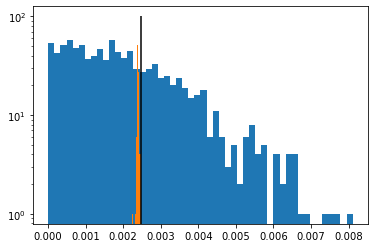

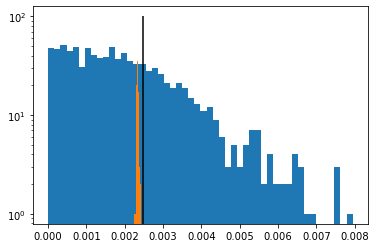

In [169]:
for l in likelihood:
    plt.figure()
    Om=cosmology['4zx4m'][l]['Om']
    Omstd=cosmology['4zx4m'][l]['Om_std']
    var=(Om-np.mean(Om))**2
    err_mean_std = np.std(var**.5, ddof=1)
    plt.hist(var**.5, bins=50)
    plt.hist(Omstd, bins=100,)
    #plt.scatter(var/Om, Omstd/Om)
    plt.vlines(np.std(Om, ddof=1), 0, 100)
    #plt.vlines(np.mean(var)**.5-err_mean_std/np.sqrt(1000), 0, 100)
    #plt.vlines(np.mean(var)**.5+err_mean_std/np.sqrt(1000), 0, 100)
#plt.yscale('log')
    #plt.scatter(np.mean(Omstd), np.mean(Omstd))
    #plt.scatter(np.mean(err)**.5, np.mean(err)**.5)
    #    , np.sqrt((Om-np.mean(Om))**2))
    #plt.vlines(np.mean(Omstd), 0, 0.008)
    #plt.hlines(np.mean(np.sqrt((Om-np.mean(Om))**2)), 0.001, 0.003)
    #plt.tick_params(axis='x', rotation=45, labelsize=20)
    #plt.xscale('log')
    plt.yscale('log')
   # plt.yscale('log')

In [170]:
plt.scatter(

SyntaxError: unexpected EOF while parsing (<ipython-input-170-5e2ca52dae45>, line 1)

# Forecast

In [180]:
forecast4x4=edit.load_pickle('/pbs/throng/lsst/users/cpayerne/ClusterLikelihoods_data/Covariances/Fisher_covariance.pickle')

In [184]:
forecast4x4

{'4zx4m': {'Poissonian': array([[ 3.76873719e-06, -2.05737551e-06],
         [-2.05737551e-06,  1.35418873e-06]]),
  'Gaussian': array([[ 5.75554086e-06, -2.92255360e-06],
         [-2.92255360e-06,  1.87307308e-06]])},
 '20zx30m': {'Poissonian': array([[ 3.27729655e-06, -1.74862855e-06],
         [-1.74862855e-06,  1.16003322e-06]]),
  'Gaussian': array([[ 5.50581960e-06, -2.61932081e-06],
         [-2.61932081e-06,  1.70757569e-06]])},
 '100zx100m': {'Poissonian': array([[ 3.26467069e-06, -1.74077984e-06],
         [-1.74077984e-06,  1.15514867e-06]]),
  'Gaussian': array([[ 4.81543763e-06, -2.33996713e-06],
         [-2.33996713e-06,  1.49188057e-06]])}}

In [194]:
100*(0.0022-0.0024)/0.0022

-9.090909090909074

In [189]:
100*forecast4x4['4zx4m']['Poissonian'][0,0]**.5/(Omega_c_true + Omega_b_true)

0.6321264587190696

# Mean

Gaussian
Gaussian_full


IndexError: list index out of range

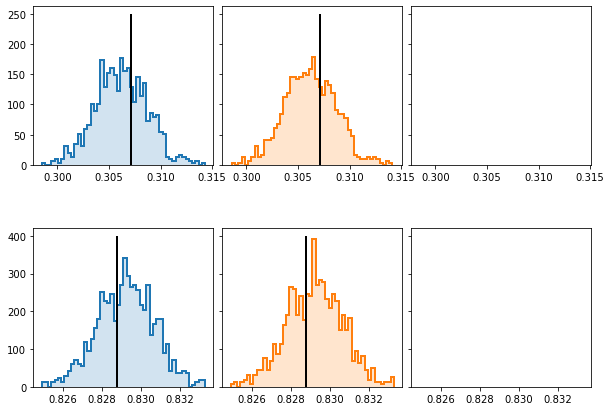

In [171]:
title = ['Gaussian','Gaussian_full']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c',]
n=11
maxsOm=250
maxss8=400
alpha=[.3, .6, .9]
fig, ax = plt.subplots(2, 3, figsize = (10,7), sharex='row', sharey='row')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.05, hspace=.4)
label = ['Poissonian', 'Gaussian', 'MPG']
show = [True, True, True]
ls=['-','-','--']
for k in range(3):
    likelihood_=likelihood[k]
    print(likelihood_)
    for i, b in enumerate(binning):
        if i >= 1: break
        err_norm=1e-3
            #try:
        try:
            
            ax[0,k].vlines(True_value[0],0,maxsOm,ls='-',color='k',linewidth=2)
            ax[1,k].vlines(True_value[1],0,maxss8,ls='-', color='k',linewidth=2)
            x=np.array(cosmology[b][likelihood_]['Om'])#/np.std(cosmology[b][likelihood_]['Om'])-1
            y=np.array(cosmology[b][likelihood_]['s8'])#/np.std(cosmology[b][likelihood_]['s8'])-1
            #cov=np.cov(x,y)
            for s,x_ in enumerate([x,y]):
                hist,x_edges =np.histogram(x_, bins=50)
                x_middle=np.array([(x_edges[i]+x_edges[i+1])/2 for i in range(len(x_edges)-1)])
                y=gaussian_filter(hist, sigma=1.5)
                if s==0: 
                    label=b
                else:label=None
                #ax[s,k].fill_between(x_middle,x_middle*0, y/scipy.integrate.simps(y,x_middle),
                 #                    color=colors[k], alpha=alpha[i],edgecolor="k", label=b)
                #ax[s,k].plot(x_middle, y/scipy.integrate.simps(y,x_middle),
                 #                    color=colors[i], alpha=1, label=b)
                ax[s,k].hist(x_, density=True, bins=50, color=colors[k],linewidth=2, alpha=.2)
                ax[s,k].hist(x_, density=True, bins=50, histtype='step',color=colors[k],linewidth=2)
             
        except: a=1

    #except: continue
for i in range(2):
    for j in range(3):
        ax[0,0].legend(frameon=False, fontsize=12, loc='upper left')
        ax[0,j].set_title(title[j], fontsize=20)
        ax[0,j].set_xlabel(r'$\Omega_m$', fontsize = 20)
        ax[1,j].set_xlabel(r'$\sigma_8$', fontsize = 20)
        ax[i,j].tick_params(axis='both', which = 'major', labelsize= 10)
        ax[0,j].set_ylim(0,maxsOm)
        ax[1,j].set_ylim(0,maxss8)
        ax[i,j].tick_params(axis='x', rotation=45)
        ax[i,j].set_yticks([], minor=False)
#plt.savefig('best_fit_distribution.pdf', bbox_inches='tight', dpi=300)

# Standard deviation

In [ ]:
title = ['G','G_full']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c',]
n=11
maxsOm=50000
maxss8=90000
alpha=[.3, .6, .9]
fig, ax = plt.subplots(1, 2, figsize = (10,5),sharex='col')
plt.rcParams['axes.linewidth']= 2
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.05, hspace=.2)
label = ['Poissonian', 'Gaussian', 'MPG']
show = [True, True, True]
ls=['-','-','--']
for k in range(2):
    likelihood_=likelihood[k]
    print(likelihood_)
    print(b)
    err_norm=1e-3
            #try:
   
    try:
        ax[0].vlines(np.std(cosmology[b][likelihood_]['Om'], ddof=1000),0,maxsOm,ls='-',color=colors[k],alpha=1,linewidth=3)
        ax[1].vlines(np.std(cosmology[b][likelihood_]['s8'], ddof=1),0,maxss8,ls='-', color=colors[k],alpha=1,linewidth=3)

        x=np.array(cosmology[b][likelihood[k]]['cov'][:,0,0]**.5)#/np.std(cosmology[b][likelihood_]['Om'])-1
        y=np.array(cosmology[b][likelihood[k]]['cov'][:,1,1]**.5)#/np.std(cosmology[b][likelihood_]['Om'])-1
        x_=[x,y]
        for s, x in enumerate(x_):
            hist,x_edges =np.histogram(x, bins=150)
            x_middle=np.array([(x_edges[i]+x_edges[i+1])/2 for i in range(len(x_edges)-1)])
            y=gaussian_filter(hist, sigma=2)
            ax[s].fill_between(x_middle,x_middle*0, y/scipy.integrate.simps(y,x_middle),
                                 color=colors[k], alpha=0.1)
            #ax[i,s].hist(x,density=True, color=colors[k],bins=50, alpha=.5)
            ax[s].plot(x_middle,y/scipy.integrate.simps(y,x_middle), alpha=1,color=colors[k], label=title[k])

    except:a=1
ax[0].legend()

#except: continue

Gaussian
4zx4m
Gaussian_full
4zx4m


/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: divide by zero encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: divide by zero encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
{i